# Importing Code

Importing libraries

In [ ]:
import string
import pandas
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
!pip install cleantext
!pip install pyLDAvis
from cleantext import clean
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Pre-processesing

In [ ]:
# reads json file containing caption
user_input = input("Please enter the file you would like to process and model. ")
df = pandas.read_json(user_input)

custom_stop_words = ['startupfiu', 'fiu', 'startup', 'http', 'skydeck', 'berkeley', 'miami', 'ca', 'us','cal', 'uc']
std_stop_words = stopwords.words('english')
std_stop_words += list(string.punctuation)
stop_words = custom_stop_words + std_stop_words

#tokenizes, removes: emoji, numbers, punctuation, and makes all words lowercase
def tokenize_lowercase(text):
    tokens = word_tokenize(text)
    new_text = [word for word in tokens if word.isalpha()]
    stopwords_removed = [token.lower() for token in new_text if token.lower() not in stop_words]
    return stopwords_removed

df['caption'] = df['caption'].apply(tokenize_lowercase)

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    if isinstance(sentence, list):  # If input is a list of tokens
        sentence = " ".join(sentence)  # Convert list to string
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # Convert nltk POS tags to WordNet tags
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # Lemmatize each word based on its POS tag
    lemmatized_tokens = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_tokens.append(word)
        else:
            lemmatized_tokens.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_tokens

# Apply the lemmatization function directly to the 'caption' column of the DataFrame
df['lemmatized_caption'] = df['caption'].apply(lemmatize_sentence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Please enter the file you would like to process and model. berkeley_combined.json


# Creating skLearn Topic Model

In [ ]:
# Example text data
documents = df['lemmatized_caption'].astype(str)

# Step 1: Create a document-term matrix
vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.85)
doc_term_matrix = vectorizer.fit_transform(documents)

# Step 2: Train the LDA model
num_topics = 5 # Number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(doc_term_matrix)

# Step 3: Interpret the topics
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

num_top_words = 10  # Number of top words to display for each topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, num_top_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0:
student intern register fair entrepreneurship program join internship virtual ucberkeley
Topic 1:
hack link bio join application hackathon learn apply team world
Topic 2:
innovation day demo batch ai investor join pitch tech team
Topic 3:
cohort read fall spring batch hotdesk advisor ai new raise
Topic 4:
apply accelerator founder application innovation global program batch advisor day


#Average likes for each topic in SKLearn LDA model

In [ ]:
import numpy as np

# Transform the documents to topic distribution
topic_distribution = lda_model.transform(doc_term_matrix)

# Assign the dominant topic to each document
df['dominant_topic'] = np.argmax(topic_distribution, axis=1)

average_likes_per_topic_LDA = df.groupby('dominant_topic')['likesCount'].mean()

print(average_likes_per_topic_LDA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dominant_topic
0    20.250000
1    44.748466
2    23.373786
3    18.247934
4    16.679012
Name: likesCount, dtype: float64


#Graph of likes in SKLearn model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


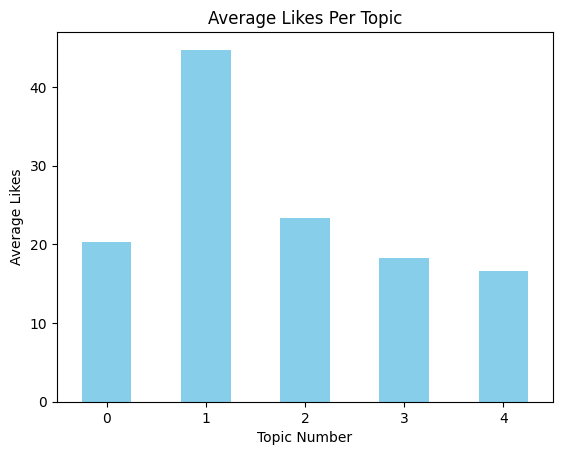

In [ ]:
import matplotlib.pyplot as plt

average_likes_per_topic_LDA.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Average Likes')
plt.title('Average Likes Per Topic')
plt.xticks(rotation=0)
plt.show()

#Visualizing SkLearn Topic Model

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
sklearn_display = pyLDAvis.lda_model.prepare(lda_model, doc_term_matrix, vectorizer)
pyLDAvis.display(sklearn_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Training and creating a genSim Topic Model

In [ ]:
# Read data from JSON file into DataFrame
df['tokenized_caption'] = df['lemmatized_caption']

# Create a dictionary from the preprocessed captions
dictionary = Dictionary(df['tokenized_caption'])

# Filter out tokens that appear in less than 5 documents or more than 50% of documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the captions to bag-of-words representation
corpus = [dictionary.doc2bow(caption) for caption in df['tokenized_caption']]

# Build the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=20, iterations=400, eval_every=1)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Calculate coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokenized_caption'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nCoherence Score: {coherence_lda}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 0.020*"http" + 0.017*"read" + 0.014*"startup" + 0.014*"innovation" + 0.013*"learn" + 0.013*"program" + 0.011*"partner" + 0.011*"executive" + 0.011*"new" + 0.010*"director"
Topic 1: 0.031*"startup" + 0.024*"innovation" + 0.021*"day" + 0.018*"apply" + 0.018*"investor" + 0.017*"founder" + 0.017*"batch" + 0.017*"demo" + 0.016*"pitch" + 0.016*"accelerator"
Topic 2: 0.021*"cohort" + 0.019*"ai" + 0.018*"http" + 0.015*"hack" + 0.013*"venture" + 0.011*"batch" + 0.011*"hackathon" + 0.010*"read" + 0.010*"spring" + 0.010*"build"
Topic 3: 0.027*"register" + 0.027*"intern" + 0.024*"student" + 0.024*"fair" + 0.018*"http" + 0.016*"startup" + 0.015*"internship" + 0.013*"virtual" + 0.013*"join" + 0.012*"tech"
Topic 4: 0.023*"bio" + 0.023*"apply" + 0.022*"link" + 0.022*"join" + 0.020*"application" + 0.015*"team" + 0.012*"hack" + 0.012*"accelerator" + 0.011*"learn" + 0.010*"founder"

Coherence Score: 0.46781316427214126


#Extracting captions and likes from gensim generated topics

In [ ]:
# Extract topics from the model
topics = lda_model.show_topics(formatted=False)

# Assign topics to captions
df['topic'] = df['tokenized_caption'].apply(lambda x: sorted(lda_model.get_document_topics(dictionary.doc2bow(x)), key=lambda x: -x[1])[0][0])

# Calculate average likes for each topic
average_likes_per_topic_gensim = df.groupby('topic')['likesCount'].mean()

print(average_likes_per_topic_gensim)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic
0    16.348387
1    19.222222
2    31.693182
3    27.619718
4    28.775281
Name: likesCount, dtype: float64


#Visualizing gensim Topic Model

In [ ]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Visualizing likes per gensim topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


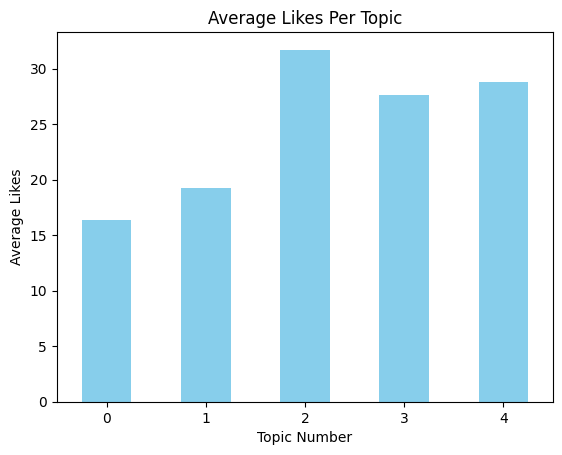

In [ ]:
import matplotlib.pyplot as plt

average_likes_per_topic_gensim.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Average Likes')
plt.title('Average Likes Per Topic')
plt.xticks(rotation=0)
plt.show()

# NMF Model

In [ ]:
from sklearn.decomposition import NMF
import ipywidgets as widgets
from IPython.display import display

num_topics = 5

# Creating NMF model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(doc_term_matrix)

feature_names = vectorizer.get_feature_names_out()

# Display topics
def display_nmf_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

def display_topic_words(n_top_words):
    display_nmf_topics(nmf_model, feature_names, n_top_words)

# Create a slider for choosing number of top words
slider = widgets.IntSlider(value=10, min=1, max=20, step=1, description='Top words:')
widgets.interactive(display_topic_words, n_top_words=slider)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(IntSlider(value=10, description='Top words:', max=20, min=1), Output()), _dom_classes=('…

In [ ]:
import numpy as np

# Transform the documents to topic distribution
topic_distribution = nmf_model.transform(doc_term_matrix)

# Assign the dominant topic to each document
df['dominant_topic'] = np.argmax(topic_distribution, axis=1)

average_likes_per_topic = df.groupby('dominant_topic')['likesCount'].mean()

print(average_likes_per_topic)

dominant_topic
0    15.445205
1    54.913043
2    18.357143
3    17.415730
4    18.232258
Name: likesCount, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Graph of average likes per topic for NMF Model:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


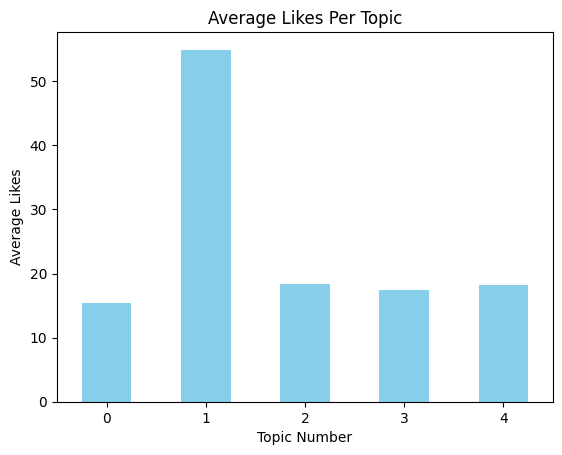

In [ ]:
import matplotlib.pyplot as plt

average_likes_per_topic.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Average Likes')
plt.title('Average Likes Per Topic')
plt.xticks(rotation=0)
plt.show()

#Vizualize data in word cloud for NMF Model:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


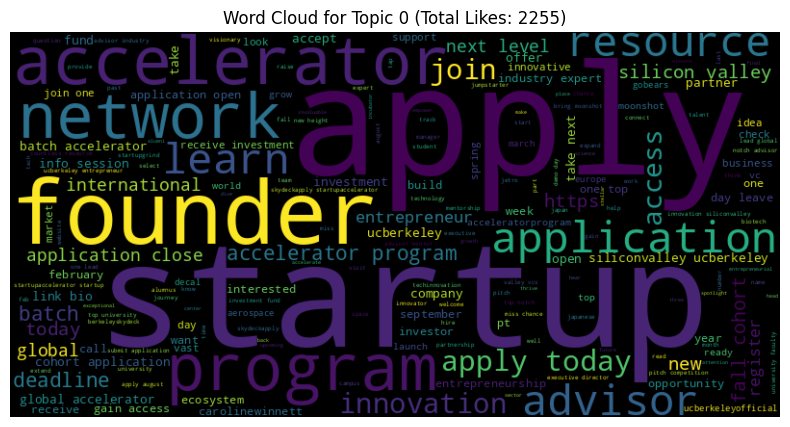

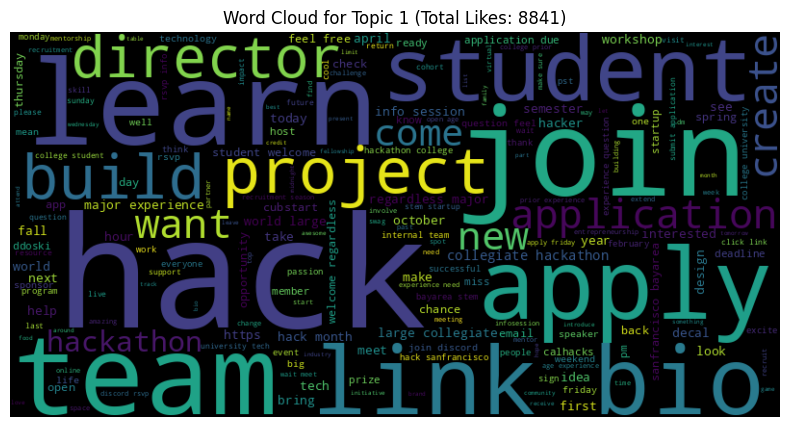

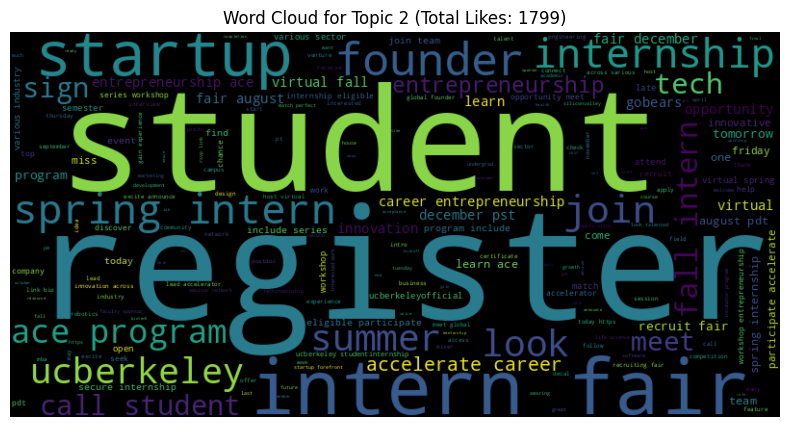

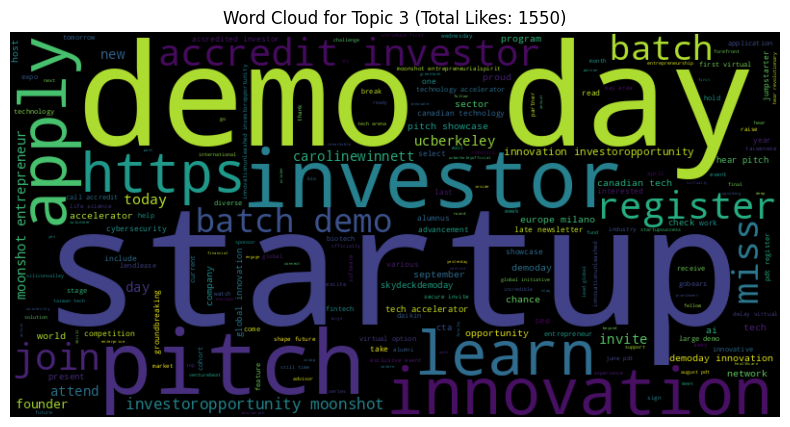

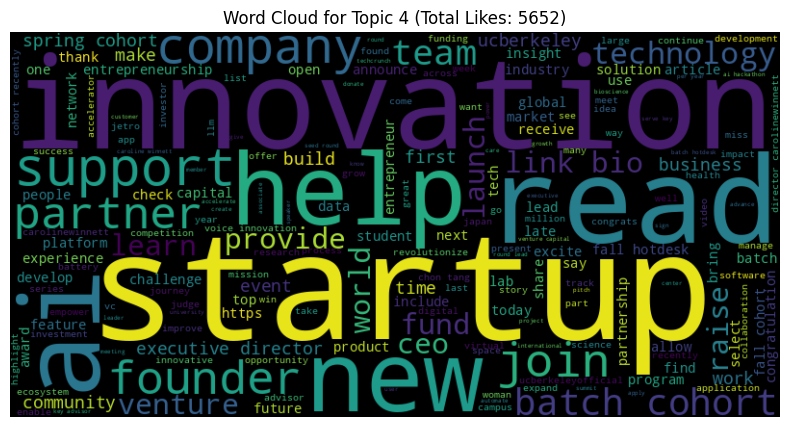

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict

!pip install wordcloud

def prepare_word_cloud_data(df):
    # grouping data by dominant_topic,aggregating likesCount with sum, concatenating tokens
    aggregated_data = df.groupby('dominant_topic').agg({
        'likesCount': 'sum',
        'tokenized_caption': lambda x: ' '.join([' '.join(tokens) for tokens in x])
    }).to_dict(orient='index')

    # word clouds for each topic weighted by likesCount
    for topic, data in aggregated_data.items():

        wordcloud = WordCloud(width=800, height=400, max_words=200).generate_from_text(data['tokenized_caption'])

        # display image
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Topic {topic} (Total Likes: {data["likesCount"]})')
        plt.axis("off")
        plt.show()


prepare_word_cloud_data(df)

#Visualizing NMF Model

In [82]:
import pyLDAvis

# Ensure 'documents' is a list of all your document strings
doc_lengths = [len(doc.split()) for doc in documents]

# Vocabulary and term frequencies from the CountVectorizer
vocab = vectorizer.get_feature_names_out()
term_frequency = np.asarray(doc_term_matrix.sum(axis=0)).ravel().tolist()

# Adding a small number to avoid division by zero
epsilon = 1e-6
doc_topic_dists = nmf_model.transform(doc_term_matrix) + epsilon
doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)[:, np.newaxis]

# Normalize topic-term distributions
topic_term_dists = nmf_model.components_
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1)[:, np.newaxis]

# Check if normalization was successful
if np.any(np.isnan(doc_topic_dists)):
    raise ValueError("NaN values found in document-topic distributions after normalization.")

# Prepare the data for pyLDAvis
data = {
    'topic_term_dists': topic_term_dists,
    'doc_topic_dists': doc_topic_dists,
    'doc_lengths': doc_lengths,
    'vocab': vocab,
    'term_frequency': term_frequency
}

# Generate the visualization
vis_data = pyLDAvis.prepare(**data)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



# Synthetic Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load existing data from Excel sheet
existing_data = pd.read_excel("existing_data.xlsx")

# Generate synthetic data
num_events = len(existing_data)

# Generate synthetic event names
synthetic_event_names = ["Synthetic Event " + str(i+1) for i in range(num_events)]

# Generate synthetic attendee numbers using a normal distribution
mean_attendees = existing_data["# Attendes"].mean()
std_attendees = existing_data["# Attendes"].std()
synthetic_attendees = np.round(np.random.normal(mean_attendees, std_attendees, num_events))

# Generate synthetic dates within a specified range (e.g., 2024-01-01 to 2024-12-31)
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')
synthetic_dates = pd.date_range(start_date, end_date, periods=num_events)

# Generate synthetic activation statuses (1 or 0)
synthetic_activation = np.random.choice([0, 1], size=num_events)

# Create a DataFrame for synthetic data
synthetic_data = pd.DataFrame({
    "Name of the Event": synthetic_event_names,
    "# Attendes": synthetic_attendees,
    "Date": synthetic_dates,
    "Activation": synthetic_activation
})

# Save synthetic data to Excel
synthetic_data.to_excel("synthetic_data.xlsx", index=False)

# Other Datasets

In [ ]:
import pandas as pd

# Paths to your JSON files
file_paths = ['path_to_first_file.json', 'path_to_second_file.json', 'path_to_third_file.json']

# Load each file into a DataFrame and append it to a list
dataframes = [pd.read_json(path) for path in file_paths]

# Concatenate all DataFrames into one
combined_dataframe = pd.concat(dataframes, ignore_index=True)

# Now you can save it or do whatever you want with it
# Save the combined DataFrame to a new JSON file, for example
combined_dataframe.to_json('combined_file.json', orient='records', lines=True)

# If you want to work with it further, you can do that too
print(combined_dataframe.head())  # Just to check the first few rows